In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy
from IPython.display import clear_output

np.random.seed(99)

In [2]:
def lin2db(x):
    return 10.0*np.log10(x)

def db2lin(x):
    return 10.0**(x/10.0)

def lin2dbm(x):
    return 10.0*np.log10(x)+30.0

def dbm2lin(x):
    return 10.0**(x/10.0 - 3.0)

In [3]:
def eCDF(data):
    x = np.sort(data)
    y = np.arange(0, len(data)) / len(data)

    return x, y  

In [4]:
# Functions related to positioning and distances

def random_ue_positions(num_ue, cov_side):
    ''' 
    Returns a random position vector within the coverage area.
    
    Parameters
    ----------
    cov_side : int, float
        The side [in m] of the coverage area.
    num_ue : int
        The number of UEs.
    '''
    
    ue_positions = np.zeros((num_ue, 2))
    
    for ue in range(num_ue):
        ue_positions[ue] = [np.random.rand() * cov_side, np.random.rand() * cov_side]
        
    return ue_positions


def ap_positions(num_ap, cov_side):
    ''' 
    Returns the APs positions based on the number of APs.
    
    Parameters
    ----------
    num_ap : int
        The number of APs.
    cov_side : int, float
        The side [in m] of coverage area.
    '''
    
    if np.sqrt(num_ap).is_integer():
        
        side_ap_quantity = int(np.sqrt(num_ap))
        
        ap_area_side = cov_side // side_ap_quantity
        
        x_pos, y_pos = np.meshgrid(np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side),
                                   np.arange(0.5 * ap_area_side,
                                             cov_side,
                                             ap_area_side))
 
        aps_pos = np.column_stack((x_pos.ravel(), y_pos.ravel()))
    
        return aps_pos
    
    else:
        
        print('Number of APs must be a perfect square')


def distance(ue_pos, ap_pos, ref_distance=1):
    ''' 
    Returns the distance [in m] between an UE and an AP. If distance is lower than reference distance, it returns the reference distance.
    
    Parameters
    ----------
    ue_pos : int, float
        The UE position.
    ap_pos : int, float
        The AP position.
    ref_distance : int, float
        The reference distance [in m] from which the gain is calculated.
    '''

    dis_matrix = np.zeros((ue_pos.shape[0], ap_pos.shape[0]))
    
    for ue in range(ue_pos.shape[0]):
        for ap in range(ap_pos.shape[0]):
            dis = np.sqrt(((ue_pos[ue])[0] - (ap_pos[ap])[0])**2
                          + ((ue_pos[ue])[1] - (ap_pos[ap])[1])**2)

            if dis >= ref_distance:
                dis_matrix[ue, ap] = dis
            else:
                dis_matrix[ue, ap] = ref_distance

    return dis_matrix

In [5]:
def fpc_algorithm(path_loss, max_power, noise_power, compesation_factor, SNR):
    target_power  = SNR + noise_power + 30
    optimal_power = np.zeros((path_loss.shape[0]))

    for i in range(path_loss.shape[0]):
        beta = np.outer(path_loss[i:], path_loss[i,:].T)
        optimal_power[i] = np.min([max_power, db2lin(target_power) * (np.sqrt(np.trace(beta))) ** (-compesation_factor)])

    return optimal_power

In [6]:
def stepwise_removal(gain_matrix, distance_mat, SINR=0):

    matrix_Z = np.zeros((gain_matrix.shape[0], gain_matrix.shape[0]))
    gain_array = np.zeros(gain_matrix.shape[0])

    aux_gain_matrix = copy.deepcopy(gain_matrix)
    
    for i in range(gain_matrix.shape[0]):
        gain_array[i] = sum(gain_matrix[i])

    for i in range(gain_matrix.shape[0]):
        matrix_Z[i] = gain_array / gain_array[i]
    
    target_SINR = db2lin(SINR) 
    
    while True:

        eigenvalues_matrix = np.linalg.eig(matrix_Z)[0]
        eigenvector_matrix = np.linalg.eig(matrix_Z)[1]
        
        max_eigenvalue = eigenvalues_matrix.max()
        index = np.where(eigenvalues_matrix == max_eigenvalue)
        
        max_eigenvector = eigenvector_matrix[index] 
        
        max_achievable_SINR = 1 / (max_eigenvalue - 1)
       

        if max_achievable_SINR >= target_SINR:
            
            power_vector = max_eigenvector
            break
            
        else:

            max_value = float('-inf')
            max_j = 0

            for j in range(matrix_Z.shape[0]):
             
                soma = sum(matrix_Z[j]) + sum(np.transpose(matrix_Z)[j])

                if soma > max_value:
                    max_value = soma
                    max_j = j

            matrix_Z = np.delete(matrix_Z, max_j, 0)
            matrix_Z = np.delete(matrix_Z, max_j, 1) 
            aux_gain_matrix = np.delete(aux_gain_matrix, max_j, 0)
            distance_mat = np.delete(distance_mat, max_j, 0)

    return power_vector, distance_mat

In [7]:
def gain(hor_distance, shadow):
    
    return db2lin(- shadow - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

In [8]:
# Functions related to channel modeling

def snr_cellfree(hor_distance, power):

    return db2lin(- 2*np.random.randn() + power + 96 - 30.5 -36.7*np.log10(np.sqrt(hor_distance**2 + 10**2)))

def channel_gain(snr):

    channel_matrix = np.zeros(snr.shape)
    for ue in range(snr.shape[0]):
        channel_matrix[ue,:] = np.sqrt(snr[ue, :])
        
    return channel_matrix

In [9]:
def mmse_sinr(channel_m):

    M = channel_m.shape[1]
    sinr = np.zeros(channel_m.shape[0])
    sum = 0
    
    for ue in range(channel_m.shape[0]):
        
        sum += channel_m[ue] @ channel_m[ue].T
        
    for ue in range(channel_m.shape[0]):
         
        sinr[ue] = channel_m[ue].T @ np.linalg.inv(sum - channel_m[ue] @ channel_m[ue].T + np.eye(M)) @ channel_m[ue]
        
    return sinr

In [43]:
def simulation(ue_quantity):

    num_ue = ue_quantity
    num_ap = 64
    cov_side = 400 # [m]
    seeds = 100
    noise_p = -96 # [dBm]
    max_power = dbm2lin(30)
    comp_factors = np.arange(0.05, 1, 0.05)
    
    total_sinr_mp = np.zeros((num_ue, seeds, 19))
    total_sinr_fpc = np.zeros((num_ue, seeds, 19))

    total_power_mp = np.zeros((num_ue, seeds, 19))
    total_power_fpc = np.zeros((num_ue, seeds, 19))
    
    counter = 0
    
    for c_fac in np.arange(0.05, 1, 0.05):
        for seed in range(seeds):
            
            ue_pos = random_ue_positions(num_ue, cov_side)
            ap_pos = ap_positions(num_ap, cov_side)
            distances = distance(ue_pos, ap_pos)
            
            
            shadowing = 2*np.random.randn(num_ue, num_ap)
            gains = gain(distances, shadowing)
            
            
            # Max Power
            power_mp = np.ones((num_ue, num_ap)) * max_power
            
            
            # Fractional Power Control
            power_fpc = fpc_algorithm(gains, max_power, noise_p, c_fac, 0)
            fpc_matrix = np.ones((num_ue, num_ap))
            
            for row in range(num_ue):
                
                fpc_matrix[row] = fpc_matrix[row] * power_fpc[row]  
                
                
            snr_mp = snr_cellfree(distances, lin2dbm(power_mp)) 
            snr_fpc = snr_cellfree(distances, lin2dbm(fpc_matrix))
            
            channels_mp = channel_gain(snr_mp)
            channels_fpc = channel_gain(snr_fpc)
            
            print('seed: ', seed)
    
            total_sinr_fpc[:, seed, counter] = mmse_sinr(channels_fpc)
            total_sinr_mp[:, seed, counter] = mmse_sinr(channels_mp)
            
            clear_output(wait=True)
        counter += 1

    return total_sinr_fpc, total_sinr_mp, 

seed:  99


In [50]:
fpc_algorithm(gains, max_power, noise_p, 0.95, 0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

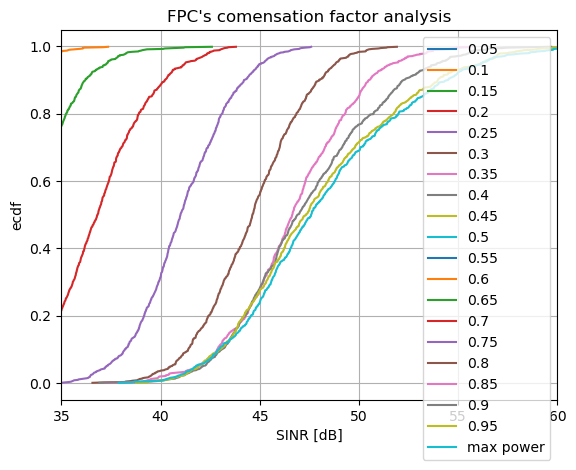

In [48]:
for i in range(counter):
    fpc_sinr_db = lin2db(total_sinr_fpc[:,:,i])
    ecdf_fpc_sinr_db = eCDF(fpc_sinr_db.flatten())

    plt.plot(ecdf_fpc_sinr_db[0], ecdf_fpc_sinr_db[1], label=np.round(comp_factors[i],3))

mp_sinr_db = lin2db(total_sinr_mp[:,:,i])
ecdf_mp_sinr_db = eCDF(mp_sinr_db.flatten())

plt.plot(ecdf_mp_sinr_db[0], ecdf_mp_sinr_db[1], label='max power')
    
plt.grid()
plt.xlabel('SINR [dB]')
plt.ylabel('ecdf')
plt.xlim(35, 60)
plt.legend()
plt.title("FPC's comensation factor analysis")

plt.savefig('Compensation_factor_evaluation.pdf')